In [1]:
#using MKL
using Distributed
using SparseArrays
using SharedArrays
using Arpack
using KrylovKit
using LaTeXStrings
using DelimitedFiles
using PyPlot
using Combinatorics
using Statistics
using ThreadTools
using Base.Threads
using LinearAlgebra
using JLD
using Interpolations

In [3]:
begin
    function Rot(θ)
        return [cos(θ) -sin(θ); sin(θ) cos(θ)]
    end
    M = 6 #cutoff
    Mlist = [[i,j]-[M+1,M+1] for i in 1:2*M+1 for j in 1:2*M+1]  
    aM = 1
    prefactor = 495 #meV*A^2
    meff = 1.0 #effective mass
    V = 0.0 #mev
    ψ = 0.0
    dMBZ = (4*pi/(3*aM))
    hbar = 4.135667696 * 10^(3)* 10^(-15) / 2 / pi  # meV* second
    me = 0.51099895 * 10^(3) * 10^(6) #meV/c^2
    m_eff = meff * me
    kin = -hbar^2 / 2 / m_eff * (299792458)^2
    kin = (kin/(1*10^-18)) #meV*nm^2
    kplus = (4*pi/(3*aM))*[-sqrt(3)/2,-1/2]
    kminus = (4*pi/(3*aM))*[-sqrt(3)/2,1/2]
    b1 = (4*pi/(sqrt(3)*aM))*[1,0]
    b2 = Rot(pi/3)*b1
    b3 = Rot(2*pi/3)*b1
    b4 = Rot(3*pi/3)*b1
    b5 = Rot(4*pi/3)*b1
    b6 = Rot(5*pi/3)*b1
    G1 = b1
    G2 = b2
    coff = 0.1
    blist = [b1,b2,b3,b4,b5,b6]
    sigmax = [0 1; 1 0]
    sigmay = [0 -im; im 0]
    sigmaz = [1 0; 0 -1]
"""    G11=dMBZ*[1,0]
    G22=dMBZ*[0.5,sqrt(3)/2]
    G33=dMBZ*[-0.5,sqrt(3)/2]
    G44=dMBZ*[-1,0]
    G55=dMBZ*[-0.5,-sqrt(3)/2]
    G66=dMBZ*[0.5,-sqrt(3)/2]"""
    a1 = aM*[sqrt(3)/2,-1/2]
    a2 = aM*[0,1]
    function find_U0(epsilon,aM)
      U0 = esquare/(4*pi*epsilon*epsilon_0*(aM))
      return U0*(6.241509*10^(18))
    end
    const esquare = (1.602176634*10^(-19))^2
    const epsilon_0 = 8.8541878128*10^(-12)
  #  U0 = 0.001 #Strength of the interaction (eV)
end

8.854187812799999e-12

In [4]:
kin

-38.09982114424051

In [16]:
b1

2-element Vector{Float64}:
 7.255197456936871
 0.0

In [14]:
function Ham(k)
    H = zeros(ComplexF64,(2*M+1)^2,(2*M+1)^2)
    for m in -M:M
        for n in -M:M
            p = (n+M) + (m+M)*(2*M+1) +1
            kt = (k +m*b1 + n*b2)
            H[p,p] += (-kin)*norm(kt)^2 
            if m != M
                x = (n+M) + (m+1+M)*(2*M+1) +1 #b1
                H[x,p] += V*exp(im*ψ)
            end
            if n != -M
                x = (n-1+M) + (m+M)*(2*M+1) +1 #b5 = -b2
                H[x,p] += V*exp(im*ψ)
            end           
            if n != M && m != -M
                x = (n+1+M) + (m-1+M)*(2*M+1) +1 #b3 = -b1+b2
                H[x,p] += V*exp(im*ψ)
            end
            if m != -M
                x = (n+M) + (m-1+M)*(2*M+1) +1 #b4 = -b1
                H[x,p] += V*exp(-im*ψ)
            end
            if n != M 
                x = (n+1+M) + (m+M)*(2*M+1) +1 #b2
                H[x,p] += V*exp(-im*ψ)
            end
            if n != -M && m != M
                x = (n-1+M) + (m+1+M)*(2*M+1) +1 #b6 = b1-b2
                H[x,p] += V*exp(-im*ψ)
            end
        end
    end
    return Hermitian(H)
end

Ham (generic function with 1 method)

In [15]:
Ham([0,0])

169×169 Hermitian{ComplexF64, Matrix{ComplexF64}}:
 2.16593e5+0.0im       0.0+0.0im  …       0.0+0.0im        0.0+0.0im
       0.0-0.0im  182500.0+0.0im          0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im          0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im          0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im          0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im  …       0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im          0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im          0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im          0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im          0.0+0.0im        0.0+0.0im
          ⋮                       ⋱                  
       0.0-0.0im       0.0-0.0im  …       0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im          0.0+0.0im        0.0+0.0im
       0.0-0.0im       0.0-0.0im          0.0+0.0im        0.0+0.0i

In [6]:
#Plotting the spectrum along a symmetry cut ( kplus' - gamma - kplus- kplus')
#Plotting the spectrum along a symmetry cut ( kplus' - gamma - kplus- kplus')
kplus2 = dMBZ*[sqrt(3)/2,-1/2]
gamma = dMBZ*[0,0]
kminus1 = dMBZ*[-sqrt(3)/2,1/2]
kplus1 = dMBZ*[-sqrt(3)/2,-1/2]
Mpt = 0.5*(G2-G1)
N1 = 100
N2 = 100
dx = (kminus1[1]-gamma[1])/N1
dy = (kminus1[2]-gamma[2])/N1
klist = [[0,0]]
for i in 0:N1
    kx = gamma[1] + i*dx
    ky = gamma[2]+ i*dy
    kpoint = [kx,ky]
    klist = vcat(klist,[kpoint])
end
klist = klist[2:length(klist)]
dx = (Mpt[1]-kminus1[1])/N1
dy = (Mpt[2]-kminus1[2])/N1
for i in 0:N1
    kx = kminus1[1] + i*dx
    ky = kminus1[2] +i*dy
    kpoint = [kx,ky]
    klist = vcat(klist,[kpoint])
end
dx = (gamma[1]-Mpt[1])/N1 
dy = (gamma[2]-Mpt[2])/N1
for i in 0:N1
    kx = Mpt[1] + i*dx
    ky = Mpt[2] +i*dy
    kpoint = [kx,ky]
    klist = vcat(klist,[kpoint])
end
 dx = (kplus1[1]-gamma[1])/N1
dy = (kplus1[2]-gamma[2])/N1
for i in 0:N1
    kx = gamma[1] + i*dx
    ky = gamma[2] + i*dy
    kpoint = [kx,ky]
    klist = vcat(klist,[kpoint])
end 
spectrum = [0 0]
for i in eachindex(klist)
    eiglist = eigvals(Ham(klist[i]), 1 : 5)
    ind = fill(i,length(eiglist))
    list = hcat(eiglist,ind)
    spectrum = vcat(spectrum,list)
end
spectrum = spectrum[2:end,:] ;

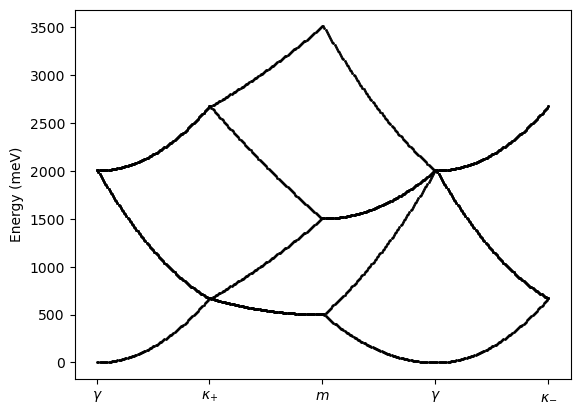

In [7]:
close("all")
fig, ax = plt.subplots()
ax.scatter(spectrum[:,2],(spectrum[:,1]) ,s=1,c="black")
ylabel("Energy (meV)")
xtickslist = [1,101,202,303,404]
#my_xticks = [L"$\kappa_{-}^{'}$",L"$\gamma$",L"$m$",L"$\gamma$",L"$\kappa_{+}^{'}$"]
my_xticks = [L"$\gamma$",L"$\kappa_{+}$",L"$m$",L"$\gamma$",L"$\kappa_{-}$"]
ax.set_xticks(xtickslist,my_xticks)
#text(100,25.5,L"C = -1 ",size = 12)
#text(100,21.5,L"C = 1 ",size = 12)
display(gcf())
#savefig("energy.pdf")

In [4]:
x_res = 50
kx_int = -(sqrt(3)/2)*dMBZ
kx_fin = (sqrt(3)/2)*dMBZ
Dx = (kx_fin - kx_int)/x_res
y_res = 50
ky_int = -(3/4)*dMBZ
ky_fin = (3/4)*dMBZ
Dy = (ky_fin - ky_int)/y_res
Dk = [Dx,Dy]
energylist = []
for ix in 0:x_res-1
    kx = kx_int + ix*Dx
    for iy in 0:y_res-1
        ky = ky_int + iy*Dy
        k_vec = [kx,ky]
        push!(energylist,eigvals(Ham(k_vec), 1 : 1)[1])
    end
end

In [ ]:
sort(energylist)

In [8]:
function lattice(a,b,c,d)
    return [a b; c d]
end
function g1g2(lattice,G1,G2)
    a = lattice[1,1]
    b = lattice[1,2]
    c = lattice[2,1]
    d = lattice[2,2]
    size = abs(det(lattice))
    sgn = sign(det(lattice))
    g1 = (1/size)*(d*sgn*G1 - c*sgn*G2)
    g2 = (1/size)*(-b*sgn*G1 + a*sgn*G2)
    return g1,g2,sgn*G1,sgn*G2,sgn
end
#k-space momentum points
function kpoints(lattice)
    a = lattice[1,1]
    b = lattice[1,2]
    c = lattice[2,1]
    d = lattice[2,2]
    limit = abs(det(lattice))
   # if b != 0 && c != 0
    xlist = []
    ylist = []
    for x in -limit:limit
        for y in -limit:limit
            if d*x-b*y >= ceil(-limit/2) && d*x-b*y <= ceil(limit/2)-1 && -c*x+a*y >= ceil(-limit/2) && -c*x+a*y <= ceil(limit/2)-1
                push!(xlist,x)
                push!(ylist,y)
            end
        end
    end
    klabel = [[xlist[i],ylist[i]] for i in eachindex(xlist)]
    return klabel
end
function mn_with_flux(k,g1,g2,phi1,phi2) #Gives the discretized momenta with inserted flux
    k = (k[1]+phi1)*g1 + (k[2]+phi2)*g2
    return k
end

mn_with_flux (generic function with 1 method)

In [9]:
klattice = [2 0 ; 0 2]
g1,g2, = g1g2(klattice,G1,G2)
klabel = kpoints(klattice)
kpts = [mn_with_flux(klabel[i],g1,g2,0,0) for i in eachindex(klabel)]

4-element Vector{Vector{Float64}}:
 [-5.441398092702654, -3.141592653589793]
 [-3.6275987284684357, 0.0]
 [-1.8137993642342183, -3.141592653589793]
 [0.0, 0.0]

In [10]:
energylist = []
for kpt in kpts
    push!(energylist,eigvals(Ham(kpt), 1 : 1)[1])
end

In [11]:
sort(energylist)

4-element Vector{Any}:
   0.0
 501.37354992788454
 501.3735499278847
 501.3735499278848

In [13]:
sum(sort(energylist)[1:3])/(-2*kin)

13.15947253478581

In [9]:
sum(sort(energylist)[1:4])

538.0577652445882

In [ ]:
668.1591

In [134]:
538.0577652445882/2

269.0288826222941

In [109]:
334.28333*2

668.56666